# Mass Variation Feature

1. Count the number before and after cuts.
2. Plot the distribution of KLFitter loglikelihood, PDNN score, and SPANet marginal probability.

In [19]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
# Fixed the bins, colors, mass arr, and labels for all plots.
# 1. Bins related parameters (reconstucted top mass)
bins_width = 1
top_bins_min, top_bins_max = 120, 230
top_bins = np.arange(top_bins_min, top_bins_max+1, bins_width)
top_bins_mid = top_bins[:-1]+bins_width/2
top_bins_dense = np.linspace(top_bins_min, top_bins_max, 1000)

# 2. bins related parameters (reconstucted W mass)
W_bins_min, W_bins_max = 40, 120
W_bins = np.arange(W_bins_min, W_bins_max+1, bins_width)
W_bins_mid = W_bins[:-1]+bins_width/2
W_bins_dense = np.linspace(W_bins_min, W_bins_max, 1000)

# 3. True top mass related parameters
mass_arr = [170, 171, 172, 173, 174, 175, 176]
mass_arr_dense = np.linspace(170, 176, 1000)

# 4. JSF related parameters
JSF_arr = [0.96, 1.0, 1.04]
JSF_arr_dense = np.linspace(0.96, 1.04, 1000)

# 5. Other paramters
loglikeli_cut = -70
assignmment_cut = 0.12
marginal_prob_cut = 0.23
pseudo_event = 100000
methods = ['KLFitter', 'PDNN', 'SPANet', 'Perfect']

# 6. Settings
states = [0, 1, 2]
state_labels = ['Unmatched', 'Incorrect', 'Correct']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
langau_fit_labels = ['Peak of Landau', 'Width of Landau', 'Mean of Gaussian', 'Variance of Gaussian', 'Fraction of Gaussian']
twogau_fit_labels = ['Mean of first Gaussian', 'Variance of first Gaussian', 'Mean of second Gaussian', 'Variance of second Gaussian', 'Fraction of second Gaussian']


## Load Data

In [37]:
def get_reco_mass(h5py_file, method, JSF):
    dic = {}
    target = ['klfitter', 'permutation_dnn', 'spanet', 'target'][methods.index(method)] # Transfer to vocab in h5py_file
    
    #Load pt, eta, phi, and mass from file. Where q1, q2 and b are the index.
    q1 = np.array([[i] for i in h5py_file[target + '/right_target/q1'][:]])
    dic['q1_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q1, axis=1).flatten()
    dic['q1_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q1, axis=1).flatten()
    dic['q1_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q1, axis=1).flatten()
    dic['q1_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q1, axis=1).flatten()

    q2 = np.array([[i] for i in h5py_file[target + '/right_target/q2'][:]])
    dic['q2_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q2, axis=1).flatten()
    dic['q2_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q2, axis=1).flatten()
    dic['q2_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q2, axis=1).flatten()
    dic['q2_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q2, axis=1).flatten()

    b = np.array([[i] for i in h5py_file[target + '/right_target/b'][:]])
    dic['b_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], b, axis=1).flatten()
    dic['b_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], b, axis=1).flatten()
    dic['b_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], b, axis=1).flatten()
    dic['b_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], b, axis=1).flatten()
    
    # Transfer to four momentum with JSF
    # px = pt*cos(phi)*JSF
    # py = pt*sin(phi)*JSF
    # pz = pt*sinh(eta)*JSF
    # E  = sqrt(m**2 + px**2 + py**2 + pz**2)
    dic['px1'] = dic['q1_pt']*np.cos(dic['q1_phi'])*JSF
    dic['py1'] = dic['q1_pt']*np.sin(dic['q1_phi'])*JSF
    dic['pz1'] = dic['q1_pt']*np.sinh(dic['q1_eta'])*JSF
    dic['E1'] = np.sqrt(dic['q1_mass']**2+dic['px1']**2+dic['py1']**2+dic['pz1']**2)

    dic['px2'] = dic['q2_pt']*np.cos(dic['q2_phi'])*JSF
    dic['py2'] = dic['q2_pt']*np.sin(dic['q2_phi'])*JSF
    dic['pz2'] = dic['q2_pt']*np.sinh(dic['q2_eta'])*JSF
    dic['E2'] = np.sqrt(dic['q2_mass']**2+dic['px2']**2+dic['py2']**2+dic['pz2']**2)

    dic['bx'] = dic['b_pt']*np.cos(dic['b_phi'])*JSF
    dic['by'] = dic['b_pt']*np.sin(dic['b_phi'])*JSF
    dic['bz'] = dic['b_pt']*np.sinh(dic['b_eta'])*JSF
    dic['bE'] = np.sqrt(dic['b_mass']**2+dic['bx']**2+dic['by']**2+dic['bz']**2)
    
    # Invariant mass calculation
    # M = sqrt((m1+m2)**2 + (px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2)
    dic['reconstructed_W_mass'] = np.sqrt((dic['E1']+dic['E2'])**2
                    - (dic['px1']+dic['px2'])**2
                    - (dic['py1']+dic['py2'])**2
                    - (dic['pz1']+dic['pz2'])**2)
    
    dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2
                    - (dic['px1']+dic['px2']+dic['bx'])**2
                    - (dic['py1']+dic['py2']+dic['by'])**2
                    - (dic['pz1']+dic['pz2']+dic['bz'])**2)

    """
    cuts
    top_bins_min < reco_m_top < top_bins_max
    W_bins_min < reco_W_top < W_bins_max
    """
    reco_top_cut = np.logical_and.reduce((dic['reconstructed_top_mass'] > top_bins_min, dic['reconstructed_top_mass'] < top_bins_max))
    reco_cut = np.logical_and.reduce((dic['reconstructed_top_mass'] > top_bins_min, dic['reconstructed_top_mass'] < top_bins_max, 
                                       dic['reconstructed_W_mass'] > W_bins_min, dic['reconstructed_W_mass'] < W_bins_max))
    
    # Check the state of the event.
    state = [1]*len(h5py_file['target/right_target/q1'][:])

    # Two permutations for q1 and q2.
    permu1 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q1'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q2'][:])
    permu2 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q2'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q1'][:])
    correct = np.logical_and(np.logical_or(permu1, permu2), h5py_file['target/right_target/b'][:] == h5py_file[target + '/right_target/b'][:])
    state = np.where(correct, 2, state)

    # Check for unmatch
    unmatch = np.logical_or.reduce((h5py_file['target/right_target/q1'][:] == -1,
                        h5py_file['target/right_target/q2'][:] == -1,
                        h5py_file['target/right_target/b'][:] == -1))
    state = np.where(unmatch, 0, state)
    
    
    if target == 'klfitter': likeli = h5py_file['klfitter/score/loglikelihood'][:]
    elif target == 'permutation_dnn': likeli = h5py_file['permutation_dnn/assignment_score'][:]
    elif target == 'spanet': likeli = h5py_file['spanet/right_target/marginal_probability'][:]
    else: likeli = [1]*len(dic['reconstructed_top_mass'])
    
    return dic['reconstructed_top_mass'], dic['reconstructed_W_mass'], state, reco_cut, likeli, reco_top_cut


In [43]:
# The reco_top_mss from ttbar_testing_mass_variation
# 0 for unmatched, 1 for incorrect, 2 for correct
reco_top_dic = {}
reco_W_dic = {}
state_dic = {}
reco_cut_dic = {}
likeli_dic = {}
reco_t_cut_dic = {} # Specifiaclly used to check event number

m, JSF = 173, 1
h5py_file = h5py.File(f'ttbar_testing_final_mass_variation_JSF={JSF:.2f}/ttbar_testing_{m}_gev.h5', "r")
for method in methods:
    print(method)
    reco_top_dic[(method, m, JSF)], reco_W_dic[(method, m, JSF)], state_dic[(method, m, JSF)], \
    reco_cut_dic[(method, m, JSF)], likeli_dic[(method, m, JSF)], reco_t_cut_dic[(method, m, JSF)] = get_reco_mass(h5py_file, method, 1)
    

KLFitter
PDNN


KeyError: "Unable to open object (object 'assignment_score' doesn't exist)"

In [14]:
data = [[len(reco_klf_dic[(m, JSF)])],  [len(reco_pdnn_dic[(m, JSF)])], [len(reco_spanet_dic[(m, JSF)])], [len(reco_perfect_dic[(m, JSF)][state_perfect_dic[(m, JSF)]==2])]]
index = ['KLFitter', 'PDNN', 'SPANet', 'Perfect']
df = pd.DataFrame(data, columns=['Event before cut'], index=index)

In [6]:
for state_i in states:
    print(f'Ratio of KLFitter {state_labels[state_i]} event before cut', len(reco_klf_dic[(m, JSF)][state_klf_dic[(m, JSF)]==state_i])/266573)
    print(f'Ratio of PDNN {state_labels[state_i]} event before cut', len(reco_pdnn_dic[(m, JSF)][state_pdnn_dic[(m, JSF)]==state_i])/266573)
    print(f'Ratio of SPANet {state_labels[state_i]} event before cut', len(reco_spanet_dic[(m, JSF)][state_spanet_dic[(m, JSF)]==state_i])/266573)


Ratio of KLFitter Unmatched event before cut 0.45320793928867514
Ratio of PDNN Unmatched event before cut 0.45320793928867514
Ratio of SPANet Unmatched event before cut 0.45320793928867514
Ratio of KLFitter Incorrect event before cut 0.30477955381827865
Ratio of PDNN Incorrect event before cut 0.16435272889602473
Ratio of SPANet Incorrect event before cut 0.1523372584620348
Ratio of KLFitter Correct event before cut 0.24201250689304618
Ratio of PDNN Correct event before cut 0.3824393318153001
Ratio of SPANet Correct event before cut 0.3944548022492901


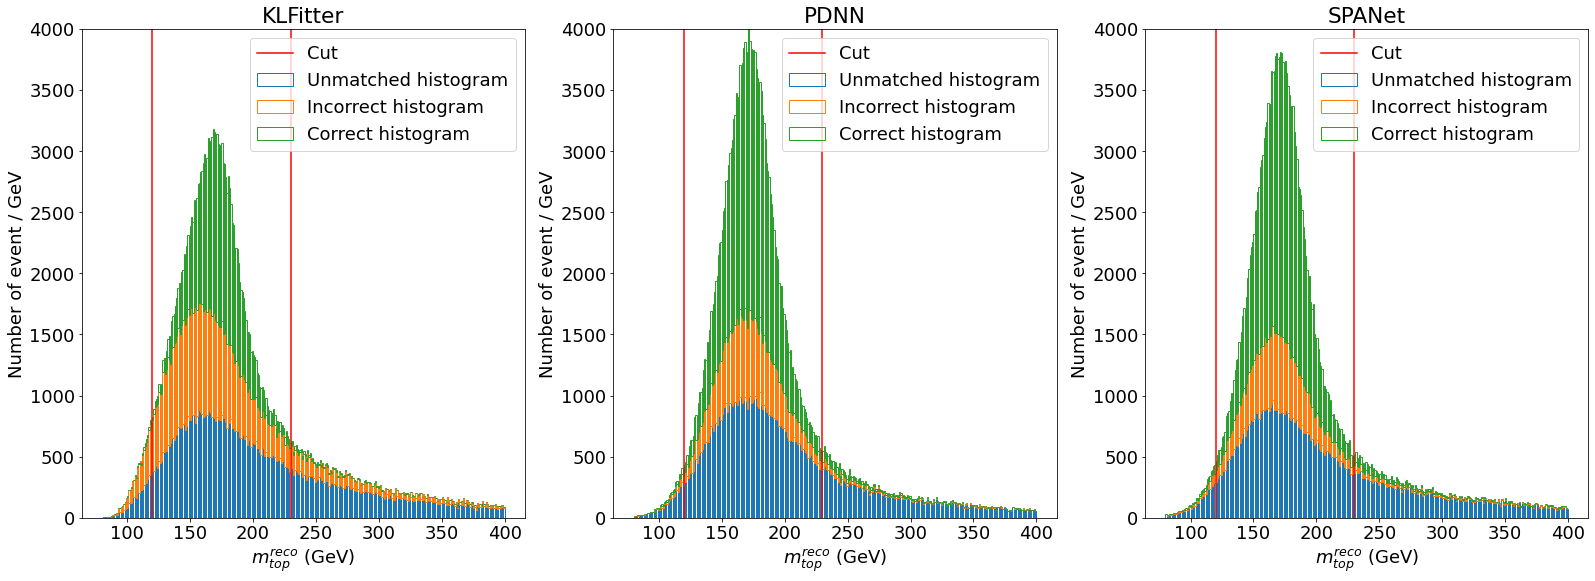

In [7]:
plt.figure(figsize=(27, 9))
plt.rcParams.update({'font.size': 18})
top_bins_wide = np.arange(80, 400+1, bins_width)
top_bins_wide_mid = top_bins_wide[:-1]+0.5

plt.subplot(1, 3, 1)

h = [0]*len(top_bins_wide_mid)
for state_i in states:
    target = reco_klf_dic[(m, JSF)][state_klf_dic[(m, JSF)]==state_i]
    hist, _ = np.histogram(target, bins=top_bins_wide)
    plt.bar(top_bins_wide_mid, hist, bottom=h, edgecolor=colors[state_i], width=1, color='None', label = state_labels[state_i] + ' histogram')
    h += hist
plt.title('KLFitter')
plt.axvline(120, c='r', label='Cut')
plt.axvline(230, c='r')
plt.xlabel('$m^{reco}_{top}}$ (GeV)')
plt.ylabel('Number of event / GeV')
plt.ylim(0, 4000)
plt.legend(loc='upper right')

plt.subplot(1, 3, 2)
h = [0]*len(top_bins_wide_mid)
for state_i in states:
    target = reco_pdnn_dic[(m, JSF)][state_pdnn_dic[(m, JSF)]==state_i]
    hist, _ = np.histogram(target, bins=top_bins_wide)
    plt.bar(top_bins_wide_mid, hist, bottom=h, edgecolor=colors[state_i], width=1, color='None', label = state_labels[state_i] + ' histogram')
    h += hist
plt.title('PDNN')
plt.axvline(120, c='r', label='Cut')
plt.axvline(230, c='r')
plt.xlabel('$m^{reco}_{top}}$ (GeV)')
plt.ylabel('Number of event / GeV')
plt.ylim(0, 4000)
plt.legend(loc='upper right')

plt.subplot(1, 3, 3)
h = [0]*len(top_bins_wide_mid)
for state_i in states:
    target = reco_spanet_dic[(m, JSF)][state_spanet_dic[(m, JSF)]==state_i]
    hist, _ = np.histogram(target, bins=top_bins_wide)
    plt.bar(top_bins_wide_mid, hist, bottom=h, edgecolor=colors[state_i], width=1, color='None', label = state_labels[state_i] + ' histogram')
    h += hist
plt.title('SPANet')
plt.axvline(120, c='r', label='Cut')
plt.axvline(230, c='r')
plt.xlabel('$m^{reco}_{top}}$ (GeV)')
plt.ylabel('Number of event / GeV')
plt.ylim(0, 4000)
plt.legend(loc='upper right')

plt.show()

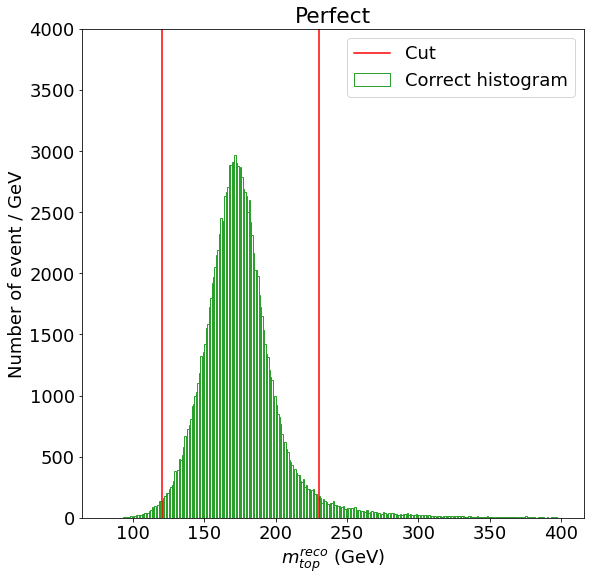

In [8]:
plt.figure(figsize=(9, 9))
h = [0]*len(top_bins_wide_mid)
target = reco_perfect_dic[(m, JSF)][state_perfect_dic[(m, JSF)]==2]
hist, _ = np.histogram(target, bins=top_bins_wide)
plt.bar(top_bins_wide_mid, hist, bottom=h, edgecolor=colors[state_i], width=1, color='None', label = state_labels[state_i] + ' histogram')
plt.title('Perfect')
plt.axvline(120, c='r', label='Cut')
plt.axvline(230, c='r')
plt.xlabel('$m^{reco}_{top}}$ (GeV)')
plt.ylabel('Number of event / GeV')
plt.ylim(0, 4000)
plt.legend(loc='upper right')

plt.show()

In [9]:
print('Number of KLFitter event after top cut', len(reco_klf_dic[(m, JSF)][top_cut_klf_dic[(m, JSF)]]))
print('Number of PDNN event after top cut', len(reco_pdnn_dic[(m, JSF)][top_cut_pdnn_dic[(m, JSF)]]))
print('Number of SPANet event after top cut', len(reco_spanet_dic[(m, JSF)][top_cut_spanet_dic[(m, JSF)]]))
print('Number of Perfect event after top cut', len(reco_perfect_dic[(m, JSF)][np.logical_and.reduce((top_cut_perfect_dic[(m, JSF)], state_perfect_dic[(m, JSF)]==2))]))

Number of KLFitter event after top cut 199856
Number of PDNN event after top cut 218428
Number of SPANet event after top cut 210314
Number of Perfect event after top cut 138742


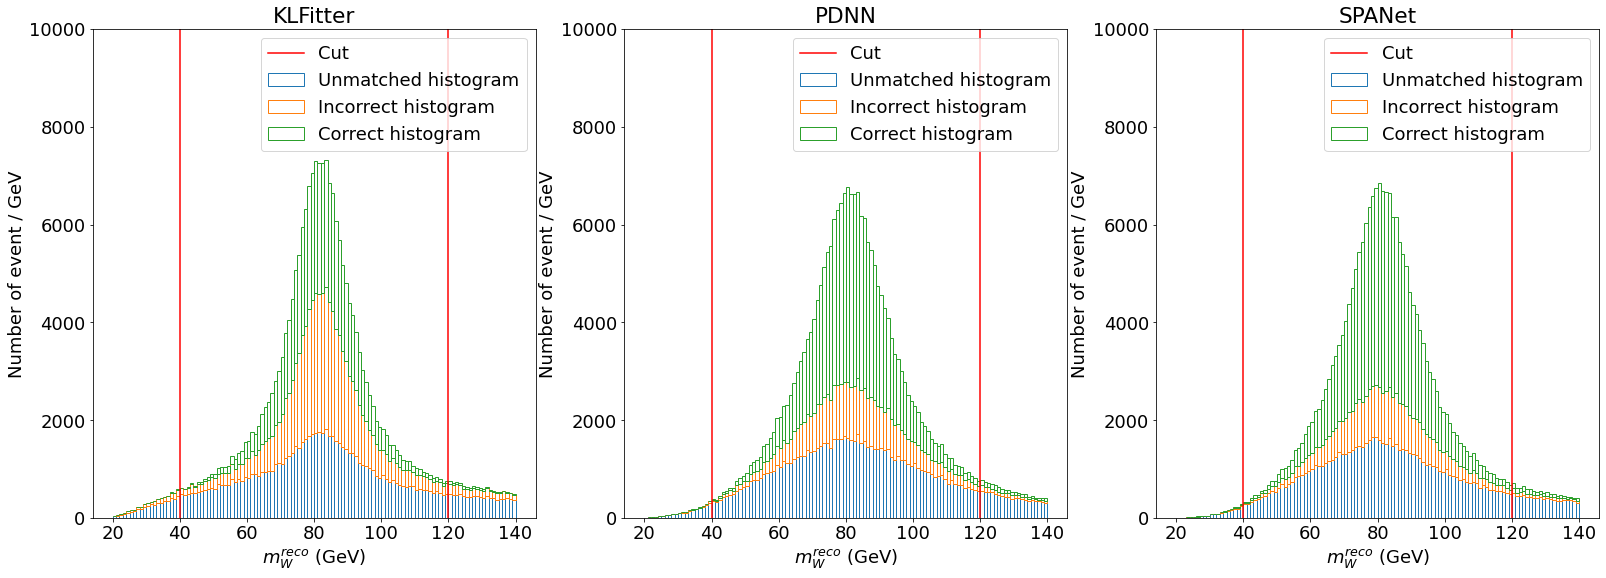

In [10]:
plt.figure(figsize=(27, 9))
plt.rcParams.update({'font.size': 18})
W_bins_wide = np.arange(20, 140+1, bins_width)
W_bins_wide_mid = W_bins_wide[:-1]+0.5

plt.subplot(1, 3, 1)

h = [0]*len(W_bins_wide_mid)
for state_i in states:
    target = W_klf_dic[(m, JSF)][state_klf_dic[(m, JSF)]==state_i]
    hist, _ = np.histogram(target, bins=W_bins_wide)
    plt.bar(W_bins_wide_mid, hist, bottom=h, edgecolor=colors[state_i], width=1, color='None', label = state_labels[state_i] + ' histogram')
    h += hist
plt.title('KLFitter')
plt.axvline(40, c='r', label='Cut')
plt.axvline(120, c='r')
plt.xlabel('$m^{reco}_{W}}$ (GeV)')
plt.ylabel('Number of event / GeV')
plt.ylim(0, 10000)
plt.legend(loc='upper right')

plt.subplot(1, 3, 2)
h = [0]*len(W_bins_wide_mid)
for state_i in states:
    target = W_pdnn_dic[(m, JSF)][state_pdnn_dic[(m, JSF)]==state_i]
    hist, _ = np.histogram(target, bins=W_bins_wide)
    plt.bar(W_bins_wide_mid, hist, bottom=h, edgecolor=colors[state_i], width=1, color='None', label = state_labels[state_i] + ' histogram')
    h += hist
plt.title('PDNN')
plt.axvline(40, c='r', label='Cut')
plt.axvline(120, c='r')
plt.xlabel('$m^{reco}_{W}}$ (GeV)')
plt.ylabel('Number of event / GeV')
plt.ylim(0, 10000)
plt.legend(loc='upper right')

plt.subplot(1, 3, 3)
h = [0]*len(W_bins_wide_mid)
for state_i in states:
    target = W_spanet_dic[(m, JSF)][state_spanet_dic[(m, JSF)]==state_i]
    hist, _ = np.histogram(target, bins=W_bins_wide)
    plt.bar(W_bins_wide_mid, hist, bottom=h, edgecolor=colors[state_i], width=1, color='None', label = state_labels[state_i] + ' histogram')
    h += hist
plt.title('SPANet')
plt.axvline(40, c='r', label='Cut')
plt.axvline(120, c='r')
plt.xlabel('$m^{reco}_{W}}$ (GeV)')
plt.ylabel('Number of event / GeV')
plt.ylim(0, 10000)
plt.legend(loc='upper right')

plt.show()

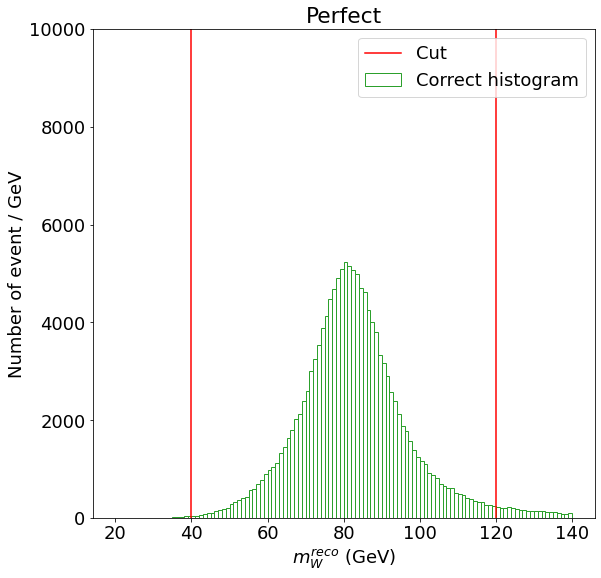

In [11]:
plt.figure(figsize=(9, 9))
h = [0]*len(W_bins_wide_mid)
target = W_perfect_dic[(m, JSF)][state_perfect_dic[(m, JSF)]==2]
hist, _ = np.histogram(target, bins=W_bins_wide)
plt.bar(W_bins_wide_mid, hist, bottom=h, edgecolor=colors[state_i], width=1, color='None', label = state_labels[state_i] + ' histogram')
plt.title('Perfect')
plt.axvline(40, c='r', label='Cut')
plt.axvline(120, c='r')
plt.xlabel('$m^{reco}_{W}}$ (GeV)')
plt.ylabel('Number of event / GeV')
plt.ylim(0, 10000)
plt.legend(loc='upper right')

plt.show()

In [12]:
print('Number of KLFitter event after W cut', len(reco_klf_dic[(m, JSF)][cut_klf_dic[(m, JSF)]]))
print('Number of PDNN event after W cut', len(reco_pdnn_dic[(m, JSF)][cut_pdnn_dic[(m, JSF)]]))
print('Number of SPANet event after W cut', len(reco_spanet_dic[(m, JSF)][cut_spanet_dic[(m, JSF)]]))
print('Number of Perfect event after W cut', len(reco_perfect_dic[(m, JSF)][np.logical_and.reduce((cut_perfect_dic[(m, JSF)], state_perfect_dic[(m, JSF)]==2))]))

Number of KLFitter event after W cut 181569
Number of PDNN event after W cut 209324
Number of SPANet event after W cut 201464
Number of Perfect event after W cut 136347


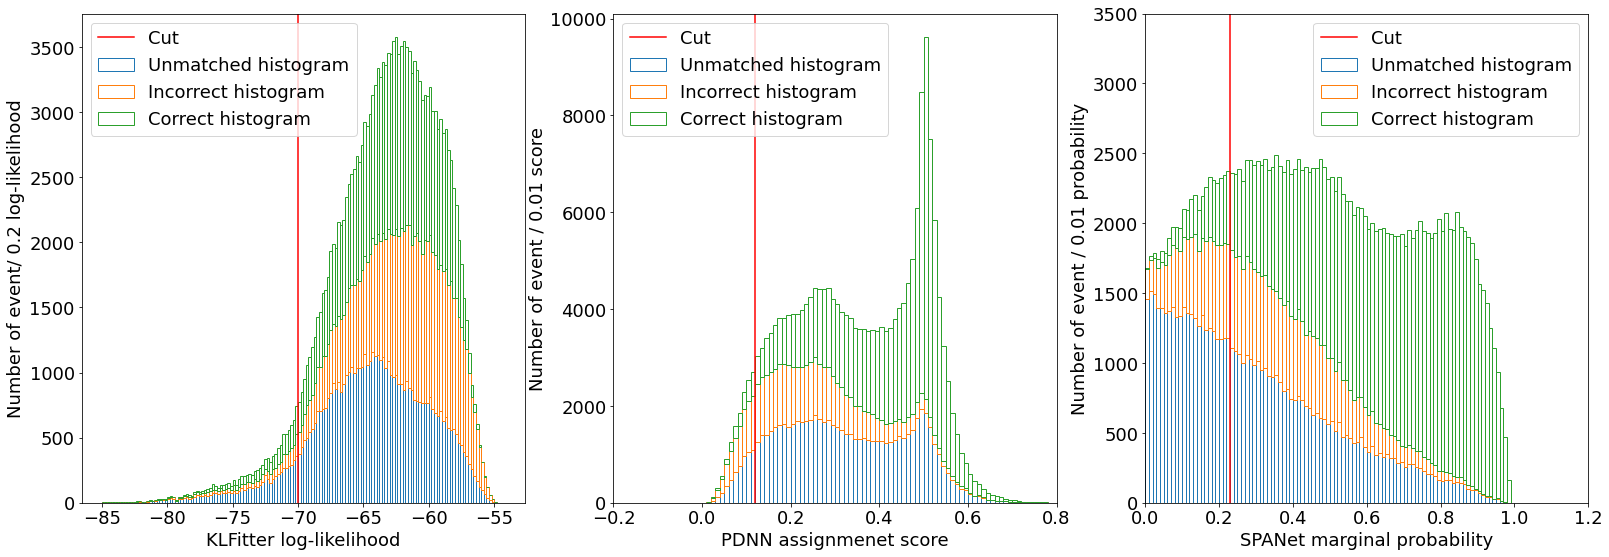

In [13]:
plt.figure(figsize=(27, 9))
plt.rcParams.update({'font.size': 18})
plt.subplot(1, 3, 1)
bins = np.arange(-85, -54, 0.2)
h = [0]*(len(bins)-1)
for state_i in states:
    target = likeli_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)]==state_i))]
    hist, _ = np.histogram(target, bins=bins)
    plt.bar(bins[:-1]+0.1, hist, bottom=h, edgecolor=colors[state_i], width=0.2, color='None', label = state_labels[state_i] + ' histogram')
    h += hist
plt.axvline(loglikeli_cut, c='r', label='Cut')
plt.xlabel('KLFitter log-likelihood')
plt.ylabel('Number of event/ 0.2 log-likelihood')
plt.legend()

plt.subplot(1, 3, 2)
bins = np.arange(0, 0.8, 0.01)
h = [0]*(len(bins)-1)
for state_i in states:
    target = likeli_pdnn_dic[(m, JSF)][np.logical_and.reduce((cut_pdnn_dic[(m, JSF)], state_pdnn_dic[(m, JSF)]==state_i))]
    hist, _ = np.histogram(target, bins=bins)
    plt.bar(bins[:-1]+0.005, hist, bottom=h, edgecolor=colors[state_i], width=0.01, color='None', label = state_labels[state_i] + ' histogram')
    h += hist
plt.axvline(assignmment_cut, c='r', label='Cut')
plt.xlabel('PDNN assignmenet score')
plt.ylabel('Number of event / 0.01 score')
plt.xlim(-0.2, 0.8)
plt.legend(loc='upper left')

plt.subplot(1, 3, 3)
bins = np.arange(0, 1, 0.01)
h = [0]*(len(bins)-1)
for state_i in states:
    target = likeli_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)]==state_i))]
    hist, _ = np.histogram(target, bins=bins)
    plt.bar(bins[:-1]+0.005, hist, bottom=h, edgecolor=colors[state_i], width=0.01, color='None', label = state_labels[state_i] + ' histogram')
    h += hist
plt.axvline(marginal_prob_cut, c='r', label='Cut')
plt.xlabel('SPANet marginal probability')
plt.ylabel('Number of event / 0.01 probability')
plt.xlim(0, 1.2)
plt.ylim(0, 3500)
plt.legend()

plt.show()

In [14]:
print('Number of KLFitter event after score cut', len(reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]>-70))]))
print('Number of PDNN event after score cut', len(reco_pdnn_dic[(m, JSF)][np.logical_and.reduce((cut_pdnn_dic[(m, JSF)], likeli_pdnn_dic[(m, JSF)]>0.12))]))
print('Number of SPANet event after score cut', len(reco_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)]>0.23))]))

Number of KLFitter event after score cut 170187
Number of PDNN event after score cut 195205
Number of SPANet event after score cut 154004


In [19]:
for state_i in states:
    print(f'Ratio of KLFitter {state_labels[state_i]} event after cut', len(reco_klf_dic[(m, JSF)][np.logical_and.reduce((state_klf_dic[(m, JSF)]==state_i, cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]>-70))])/170187)
    print(f'Ratio of PDNN {state_labels[state_i]} event after cut', len(reco_pdnn_dic[(m, JSF)][np.logical_and.reduce((state_pdnn_dic[(m, JSF)]==state_i, cut_pdnn_dic[(m, JSF)], likeli_pdnn_dic[(m, JSF)]>0.12))])/195205)
    print(f'Ratio of SPANet {state_labels[state_i]} event after cut', len(reco_spanet_dic[(m, JSF)][np.logical_and.reduce((state_spanet_dic[(m, JSF)]==state_i, cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)]>0.23))])/154004)


Ratio of KLFitter Unmatched event after cut 0.31543537402974375
Ratio of PDNN Unmatched event after cut 0.3391204118746958
Ratio of SPANet Unmatched event after cut 0.22707851744110544
Ratio of KLFitter Incorrect event after cut 0.33409132307403033
Ratio of PDNN Incorrect event after cut 0.16938090725135113
Ratio of SPANet Incorrect event after cut 0.1534830264148983
Ratio of KLFitter Correct event after cut 0.3504733028962259
Ratio of PDNN Correct event after cut 0.49149868087395304
Ratio of SPANet Correct event after cut 0.6194384561439963


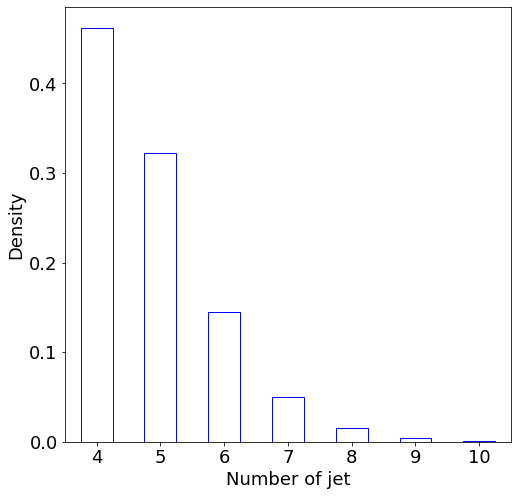

In [15]:
plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 18})
bins = np.arange(4, 14, 1)
target = h5py_file['jet_features/num_of_jets'][:]
hist, _ = np.histogram(target, bins=bins, density=True)
plt.bar(bins[:-1], hist, edgecolor='b', width=0.5, color='None')

plt.xlabel('Number of jet')
plt.ylabel('Density')
plt.xlim(3.5, 10.5)
plt.show()